# Demonstration and Validation

## Random Forest Example

Start by training the standard random forest example.

In [1]:
from tomo_challenge import load_data, load_redshift
from tomo_challenge.jax_metrics import ell_binning, compute_scores
from tomo_challenge.classifiers.random_forest import RandomForest

Found classifier Random
Found classifier RandomForest
Found classifier IBandOnly


Specify the challenge data to load:

In [2]:
bands='riz'
include_colors=True
include_errors=True

Load the training data:

In [3]:
training_file='/media/data2/tomo_challenge_data/ugrizy/training.hdf5'
train_data_arr = load_data(training_file, bands, 
                           errors=include_errors,
                           colors=include_errors, array=True)
training_z = load_redshift(training_file)
print(f'Loaded {len(train_data_arr)} training rows.')

/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


Loaded 8615613 training rows.


Load the validation data:

In [4]:
validation_file='/media/data2/tomo_challenge_data/ugrizy/validation.hdf5'
valid_data_arr = load_data(validation_file, bands, 
                           errors=include_errors,
                           colors=include_errors, array=True)
val_z = load_redshift(validation_file)
print(f'Loaded {len(valid_data_arr)} validation rows.')

Loaded 17228554 validation rows.


Initialize a random forest classifier with 4 bins:

In [5]:
nbins_rf = 4
classifier = RandomForest(bands, {'bins': nbins_rf})

Train on a fraction of the data:

In [6]:
ntrain_rf = 20000
classifier.train(train_data_arr[:ntrain_rf], training_z[:ntrain_rf])

Finding bins for training data
Fitting classifier


/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test on a fraction of the validation data:

In [7]:
nvalid_rf = 50000
idx_rf = classifier.apply(valid_data_arr[:nvalid_rf])
z_rf = val_z[:nvalid_rf]

## Jax Cosmo Scores

Calculate scores using the jax_cosmo implementation provided with tomo_challenge:

In [17]:
%time scores_rf = compute_scores(idx_rf, z_rf, metrics=['SNR_3x2', 'FOM_3x2', 'FOM_DETF_3x2'])

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 1min 7s, sys: 17.9 s, total: 1min 25s
Wall time: 1min 51s


In [18]:
scores_rf

{'SNR_3x2': 1183.4375,
 'FOM_3x2': 2127.108154296875,
 'FOM_DETF_3x2': 45.92446517944336}

## Fast Scores

Use reweighting to speed up the score calculation:

In [8]:
from zotbin.binned import *

Load the initialization data:

In [9]:
init_data = load_binned('binned_28.npz')

Calculate scores using the fast reweighting method:

In [ ]:
%time scores = get_binned_scores(idx_rf, z_rf, *init_data)

In [13]:
w = get_binned_weights(init_data[0], z_rf, idx_rf)

In [14]:
ww = jnp.array([w, w])

In [15]:
cl_out = zotbin.reweight.reweight_cl(ww, init_data[2], init_data[4])

In [33]:
nl_out, cl_index = reweight_noise_cl(ww, 20., init_data[2], init_data[3], len(init_data[1]))

In [38]:
%timeit reweight_noise_cl(ww, 20., init_data[2], init_data[3], len(init_data[1]))

711 µs ± 20.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [29]:
import jax
import jax.numpy as jnp
import functools

In [37]:
@functools.partial(jax.jit, static_argnums=(1, 4))
def reweight_noise_cl(weights, gals_per_arcmin2, ngals, noise, nell):
    """
    """
    #assert len(weights) == len(noise)
    nprobe = weights.shape[0]
    noise_out = []
    ntracers = 0
    for i in range(nprobe):
        noise_inv_in = 1 / (ngals[i] * noise[i])
        noise_inv_out = gals_per_arcmin2 * weights[i].dot(noise_inv_in)
        noise_out.append(1 / noise_inv_out)
        ntracers += len(noise_inv_out)
    noise = jnp.concatenate(noise_out)

    # Define an ordering for the blocks of the signal vector
    cl_index = []
    for i in range(ntracers):
        for j in range(i, ntracers):
            cl_index.append((i, j))
    cl_index = jnp.array(cl_index)

    # Only include a noise contribution for the auto-spectra
    def get_noise_cl(inds):
        i, j = inds
        delta = 1.0 - jnp.clip(jnp.abs(i - j), 0.0, 1.0)
        return noise[i] * delta * jnp.ones(nell)

    return jax.lax.map(get_noise_cl, cl_index), cl_index

In [16]:
def reweighted_cov(cl_out, nl_out, cl_index, ell, fsky=0.25):
    """
    """
    # This is essentially jc.angular_cl.gaussian_cl_covariance without using probes...
    cl_obs = cl_out + nl_out
    ncl = cl_obs.shape[0]
    norm = (2 * ell + 1) * jnp.gradient(ell) * fsky

    def find_index(a, b):
        if (a, b) in cl_index:
            return cl_index.index((a, b))
        else:
            return cl_index.index((b, a))

    cov_blocks = []
    for (i, j) in cl_index:
        for (m, n) in cl_index:
            cov_blocks.append(
                (find_index(i, m), find_index(j, n), find_index(i, n), find_index(j, m))
            )

    def get_cov_block(inds):
        a, b, c, d = inds
        cov = (cl_obs[a] * cl_obs[b] + cl_obs[c] * cl_obs[d]) / norm
        return cov

    # Build a sparse representation of the output covariance.
    return jax.lax.map(get_cov_block, jnp.array(cov_blocks)).reshape((ncl, ncl, len(ell)))

In [ ]:
cov_out = reweighted_cov(cl_out[-1], 

In [35]:
%timeit reweight_cl(ww, init_data[2], init_data[4]).block_until_ready()

282 µs ± 318 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


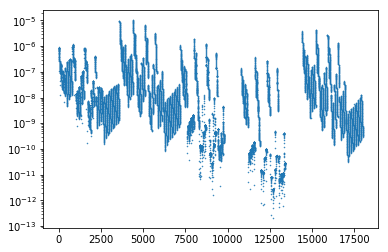

In [26]:
plt.semilogy(cl_out.reshape(-1), '.', ms=1);

In [27]:
jnp.all(jnp.isfinite(cl_out))

DeviceArray(True, dtype=bool)